# SO(5) Richardson Gaudin

First, let's import the functions and packages we need we need

In [13]:
from solve_rg_eqs import solve_rgEqs, solve_rgEqs_2, G_to_g
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Setting physical parameters. 

Note that $g$ is not $GL$, but instead
$g = \frac{G}{1-G\sum_k k}$. At $G_c = \frac{1}{\sum_k k}$, $g$ becomes singular. So, around this point I switch to using $1/g$ in the code.

Due to assumptions in the code, I currently require Nup and Ndown to be even numbers.

In [23]:
L = 3 # Very small system, just an illustration
Ne = 3
Nw = 3

N = Ne + Nw
ts = np.zeros(L)
vs = np.zeros(L)
vs[2] = 0
print(vs)
def ck(vs):
    cks = (.5*vs-1)**2+3*(1-.5*vs)-1
    return cks
print(ck(vs))


N = Ne+Nw + np.sum(vs)

dims = (L, Ne, Nw, vs)

# G_final = 1.25*(2/(np.pi*L)) # 1.5 times critical coupling?
G_final = -0.5
k = np.arange(1, 2*L+1, 2)*0.5*np.pi/L

[0. 0. 0.]
[3. 3. 3.]


Setting numerical parameters. If the following things don't work, try decreasing ``dg`` (which will change the other parameters as well). If you want more (or less) points in the output, decrease (increase) the value of ``skip``, which sets how often we remove artificial imaginary parts and save values to output (i.e. skip ``skip`` values of ``g`` before doing this).

In [24]:
dg = 0.01/L # step size of g. Scaling with N instead of L because increasing N increases difficulty
g0 = .1*dg # initial value of g
imk = dg # scale of the imaginary parts added to k
imv = g0 # scale of the imaginary parts used in the initial guess

skip=4*N # it's harder for larger N, so let's make it easy on us

Solving the Richardson-Gaudin equations.

Watch out, this could take a while. It will increment ``g`` from ``g0`` until
it has trouble converging, at which point it switches to incrementing ``1/g``.

Also, ignore things that look like error messages. 

## Wait for the evaluation to complete!
## The [*]: to the left of this should turn into a number [x]:

In [ ]:
output_df = solve_rgEqs_2(dims, G_final, k, dg=dg, g0=g0, imscale_k=imk,
                              imscale_v=imv, skip=skip)


OK, that took a while. If there's a big pink error message about division by zero, ignore it for now.

If you see an error that says something about child processes, I suggest restarting the kernel and rerunning.

Let's look at the output, stored in a Pandas DataFrame.

To store it as a CSV, uncomment lines 2 and 3 below and input a filename when prompted. Line 4 is an example of how to load the data (or other CSV data) into a Pandas dataframe.

In [17]:
print(output_df)
# filename = input('Name to save file to: ')
# output_df.to_csv(filename)
# new_df = pd.load_csv(filename)

          g         G   Re(e_0)       Im(e_0)  Re(omega_0)  Im(omega_0)  \
0  0.078400  0.057249  0.509539  8.970496e-19     0.491379     0.009998   
1  0.161344  0.091656  0.493944  1.283186e-18     0.458234     0.018717   
2  0.244288  0.113560  0.477933  1.868913e-18     0.427020     0.025479   
3  0.318310  0.127324  0.463525 -3.666922e-11     0.401187     0.030027   
4  1.101007  0.177915  0.331456  1.243688e-10     0.230620     0.037993   
5 -0.605422  0.326728  9.647688  8.802940e-08    -1.259077    -0.866755   
6 -0.237432  1.997410  2.174145 -3.651341e-10     3.260284    -1.946570   
7 -0.148978 -0.500000  1.881181  2.380021e-10     2.455874    -0.514360   

      Re(e_1)       Im(e_1)  Re(omega_1)  Im(omega_1)     energy       R_0  \
0    0.474848  2.498897e-18     0.491379    -0.009998   6.074153  1.836201   
1    0.428671  5.589622e-18     0.458234    -0.018717   5.295215  1.683028   
2    0.388401  1.484628e-17     0.427020    -0.025479   4.783373  1.546253   
3    0.35713

# Checking results with exact diagonalization

To use my exact-diagonalization code, you will need the [Quspin package](https://weinbe58.github.io/QuSpin/).
First, we import functions from my exact-diagonalization code and create a basis for ``Nup`` spin up and ``Ndown``
spin down fermions on a 1-d lattice with ``2L`` sites (since ``L`` counts only positive $k$):

In [18]:
from exact_diag import ham_op_2, find_nk, form_basis, casimir_dict, iom_dict, quantum_operator
Nup = int(Ne + np.sum(vs)/2)
Ndown = int(Nw + np.sum(vs)/2)
print(Nup)
basis = form_basis(2*L, Nup, Ndown)
print('Number of states in the basis:')
print(basis.Ns)

3
Number of states in the basis:
400


In [19]:
def Z(a,b):
    return a*b/(a-b)
def ioms(dims, g, ks, es):
    if len(dims) == 3:
        L, Ne, Nw = dims
        vs = np.zeros(L)
    else:
        L, Ne, Nw, vs = dims
    R = np.zeros(L, dtype=np.complex128)
    for i, k in enumerate(ks):
        R[i] = g*np.sum((1-.5*vs[i])*Z(k, es))
        otherks = ks[np.arange(L) != i]
        othervs = vs[np.arange(L) != i]
        R[i] -= g*np.sum(((.5*vs[i]-1)*(.5*othervs-1)-1)
                           *Z(k, otherks))
        R[i] += vs[i]*.5
    return R

In [20]:
H = ham_op_2(L, G_final, k, basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [21]:
g = output_df['g'].iloc[-1]
h = ham_op_2(L, output_df['G'].iloc[-1], k, basis)
e0 = output_df['energy'].iloc[-1]
ces = output_df[['Re(e_{})'.format(i) for i in range(Ne)]].iloc[-1] 
if max(abs(output_df[['Im(e_{})'.format(i) for i in range(Ne)]].iloc[-1])) > 10**-6:
    ces += 1j*output_df[['Im(e_{})'.format(i) for i in range(Ne)]].iloc[-1]
print(ces)
ioms_g = ioms(dims, g, k, ces)
print('Integrals of motion from hand')
print(ioms_g )
print('From dataset')
print(output_df[['R_{}'.format(i) for i in range(L)]].iloc[-1])
e02 = (2*np.sum(k*output_df[['R_{}'.format(i) for i in range(L)]].iloc[-1]) - g*np.sum(ck(vs)*k**2))/(1+g*np.sum(k)) 
e03 = (2*np.sum(k*ioms_g) - g*np.sum(ck(vs)*k**2))/(1+g*np.sum(k)) 

e, v = h.eigh()
print('Energies from RG')
print(e0)
print(e02)
print(e03)
print('ED ground state')
print(e[0])
rg_ind = np.argmin(np.abs(e-e0))
print('Smallest difference from ED at {}th state'.format(rg_ind))
print(np.min(np.abs(e-e0)))
print('Degeneracy of this state:')
print(len(e[np.abs(e - e[rg_ind]) < 10**-10]))

cs = [quantum_operator(casimir_dict(L, i, 1), basis=basis, check_herm=False, check_pcon=False, check_symm=False) 
      for i in range(L)]

print('Trv grvn state casimirs')
for c in cs:
    print(c.matrix_ele(v[:,0], v[:,0]))
print('Excited state casimirs')
for c in cs:
    print(c.matrix_ele(v[:,rg_ind], v[:,rg_ind]))

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Re(e_0)    1.881181
Re(e_1)    4.022990
Name: 7, dtype: float64
Integrals of motion from hand
[0.29527251+0.j 2.38726977+0.j 0.31745772+0.j]
From dataset
R_0    0.295273
R_1    2.387270
R_2    0.317458
Name: 7, dtype: float64
Energies from RG
32.47272127554452
32.47272127554452
(32.47272127554452+0j)
ED ground state
17.841624550719732
Smallest difference from ED at 226th state
4.662851438297366e-09
Degeneracy of this state:
3
Trv grvn state casimirs
(3.000000000000001+0j)
(3.000000000000001+0j)
(-1+0j)
Excited state casimirs
(3+0j)
(2.9999999999999996+0j)
(-1+0j)


In [22]:
Nup = int(Ne + np.sum(vs)/2)
Ndown = int(Nw + np.sum(vs)/2)
print(Nup)
basis = form_basis(2*L, Nup, Ndown)
print('Number of states in the basis:')
print(basis.Ns)

# i_ind = 1
g_ind = 3
g = output_df['g'].iloc[g_ind]

ces = np.array(output_df[['Re(e_{})'.format(i) for i in range(Ne)]].iloc[g_ind], dtype=np.complex128)
if max(abs(output_df[['Im(e_{})'.format(i) for i in range(Ne)]].iloc[g_ind])) > 10**-10:
    ces += 1j*output_df[['Im(e_{})'.format(i) for i in range(Ne)]].iloc[g_ind]
print('e_alpha here')
print(ces)
ioms_g = ioms(dims, g, k, ces)

for i_ind in range(L):
# for i, g in enumerate(output_df['g']):
    # print('g = {}'.format(g))
    print('{}th iom'.format(i_ind))
    print('v = {} here'.format(vs[i_ind]))
    Ri = quantum_operator(iom_dict(L, g, k, k1=i_ind, mult=1.), basis=basis)
    # ri = output_df['R_{}'.format(i_ind)].iloc[g_ind]
    ri = ioms_g[i_ind]
    e, v = Ri.eigh()
    print('Smallest difference')
    print(min(abs(e-ri)))
    print('Index of exact val.')
    print(np.argmin(abs(e-ri)))
    print('')

3
Number of states in the basis:
400
e_alpha here
Im(e_0)    0.463525-0.000000j
Im(e_1)    0.357136-0.000000j
Name: 3, dtype: complex128
0th iom
v = 0.0 here
p_k1, m_k1 = 3, 2
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Smallest difference
1.626880371431288e-09
Index of exact val.
386

1th iom
v = 0.0 here
p_k1, m_k1 = 4, 1
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Smallest difference
1.466080103508114e-10
Index of exact val.
73

2th iom
v = 2.0 here
p_k1, m_k1 = 5, 0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Smallest difference
0.0
Index of exact val.
197



# Using the results

## Pairons

Let's make a plot of the pairons. First, we need to get the results from the DataFrame. In output_df, the results for each pairon's real and imaginary part is stored as a row, with a name like ``Re(omega_0)``. Let's make lists of these column names:

In [6]:
real_e_index = ['Re(e_{})'.format(i) for i in range(Ne)]
im_e_index = ['Im(e_{})'.format(i) for i in range(Ne)]
real_w_index = ['Re(omega_{})'.format(i) for i in range(Nw)]
im_w_index = ['Im(omega_{})'.format(i) for i in range(Nw)]

# Is this the thing we wanted?
print(real_e_index)
print(im_e_index)
print(real_w_index)
print(im_w_index)

['Re(e_0)', 'Re(e_1)']
['Im(e_0)', 'Im(e_1)']
['Re(omega_0)', 'Re(omega_1)']
['Im(omega_0)', 'Im(omega_1)']


Let's make a plot with labels and titles and legends!

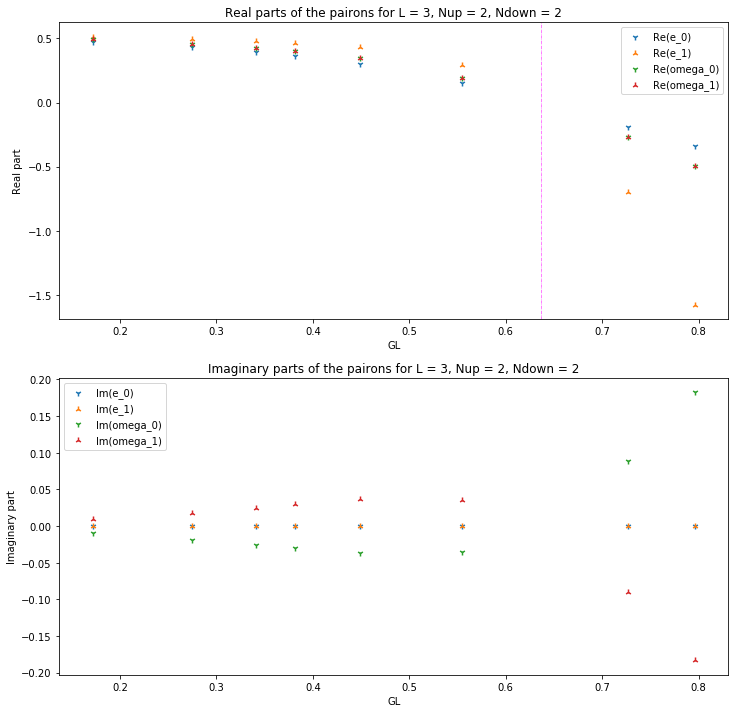

In [7]:
plt.figure(figsize=(12,12)) # Making a bigger figure for the plots

markers = ['1', '2', '3', '4', 'x', '+', '.', 'v', '^'] 
# using different shapes for the markers so we can see stacked results

plt.subplot(2,1,1) # Making 2 subplots, first for real parts
for i, ind in enumerate(real_e_index):
    # Plotting like before, but now assigning labels for the legend
    # Luckily, our rownames are decent labels already
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 
# Doing the same for real parts of omega
for i, ind in enumerate(real_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 

# Let's plot a horizontal line at 0
# plt.axhline(0)

# Let's make a thin, vertical, dotted/dashed, magenta line at G_c
g_c = L/np.sum(k)
plt.axvline(g_c, ls='-.', color='magenta', linewidth=.5)
    
# Making axes labels
plt.title('Real parts of the pairons for L = {}, Nup = {}, Ndown = {}'.format(L, Ne, Nw))
plt.xlabel('GL')
plt.ylabel('Real part')
plt.legend() 
    
plt.subplot(2,1,2) # Now moving to a second subplot
for i, ind in enumerate(im_e_index):
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 
for i, ind in enumerate(im_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i]) 

# plt.axhline(0)
# plt.axvline(g_c, ls='-.', color='magenta', linewidth=.5)    
    
plt.title('Imaginary parts of the pairons for L = {}, Nup = {}, Ndown = {}'.format(L, Ne, Nw))
plt.xlabel('GL')
plt.ylabel('Imaginary part')
plt.legend()

plt.show()

We can change the limits of the axes to get a closer look at the behavior around G_c:

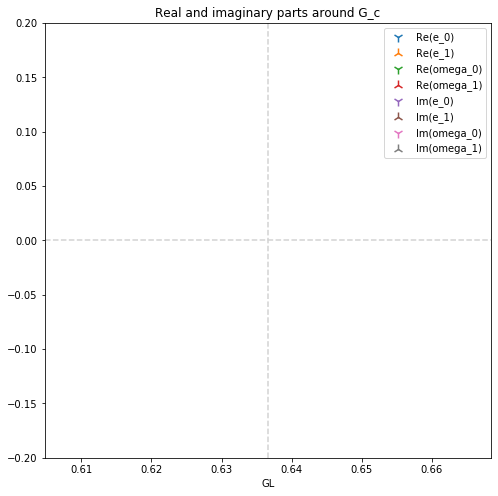

In [8]:
plt.figure(figsize=(8,8))

plt.axvline(g_c, ls = '--', color='lightgray')
plt.axhline(0, ls = '--', color='lightgray')

for i, ind in enumerate(real_e_index):
    # s is the size of the marks (not sure the units)
    # Let's make them bigger!
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(real_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(im_e_index):
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
for i, ind in enumerate(im_w_index): 
    plt.scatter(output_df['G']*L, output_df[ind], label=ind, marker=markers[i], s=100) 
    
plt.xlim(0.95*g_c, 1.05*g_c) # Looking within 5% of g_c
plt.ylim(-0.2, 0.2) # You might need to change these values

plt.legend()
plt.xlabel('GL')

plt.title('Real and imaginary parts around G_c')
plt.show()

## Energy
We can also plot energy (and other things). Let's get the energy and derivatives from the output DataFrame.

Again, if there is a division by zero error, ignore it for now. This occurs if we are taking the derivative of something too close to vertical.

In [9]:
Es = output_df['energy']
Gs = output_df['G']
# Rescaling by appropriate factors of L
es = Es/L
gs = Gs*L # different than g in previous plot

print('Taking 1st derivative')
de = np.gradient(es, gs) # derivative de/dg
print('Taking 2nd derivative')
d2e = np.gradient(de, gs) # second derivative
print('Taking 3rd derivative')
d3e = np.gradient(d2e, gs) # third


Taking 1st derivative
Taking 2nd derivative
Taking 3rd derivative


Now, let's make a 2-by-2 plot with the energy and derivatives.

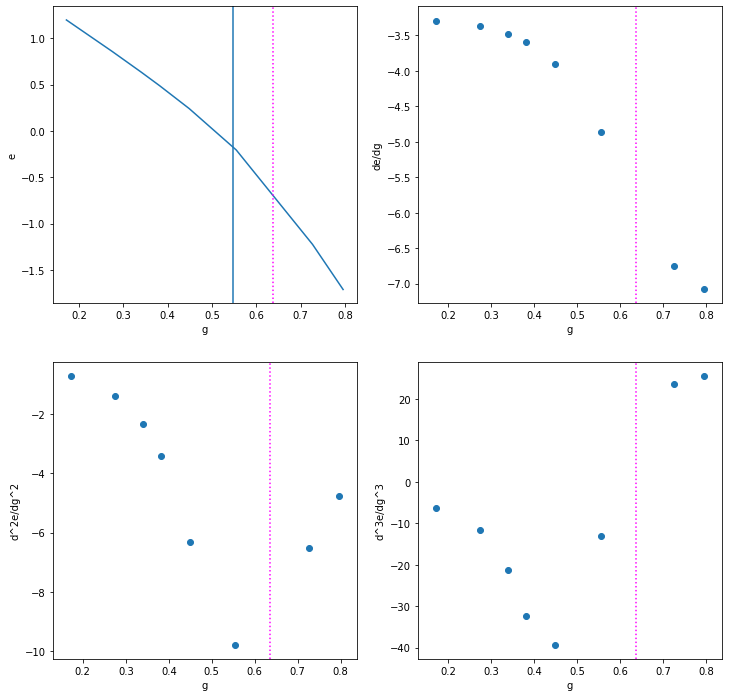

In [10]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(gs, es)
plt.xlabel('g')
plt.ylabel('e')
plt.axvline(g_c, ls=':', color='magenta')
plt.axvline(0.8585403710772574*g_c)

plt.subplot(2, 2, 2)
plt.scatter(gs, de)
plt.xlabel('g')
plt.ylabel('de/dg')
plt.axvline(g_c, ls=':', color='magenta')


plt.subplot(2, 2, 3)
plt.scatter(gs, d2e)
plt.xlabel('g')
plt.ylabel('d^2e/dg^2')
plt.axvline(g_c, ls=':', color='magenta')


plt.subplot(2, 2, 4)
plt.scatter(gs, d3e)
plt.xlabel('g')
plt.ylabel('d^3e/dg^3')
plt.axvline(g_c, ls=':', color='magenta')
# Behavior around G=0 is weird but this is due to truncation and inaccuracies in the solution around that point

plt.show()

## Momentum Distribution

Let's look at the momentum distribution within $5\%$ of my prediction for $G_c$.

No handles with labels found to put in legend.


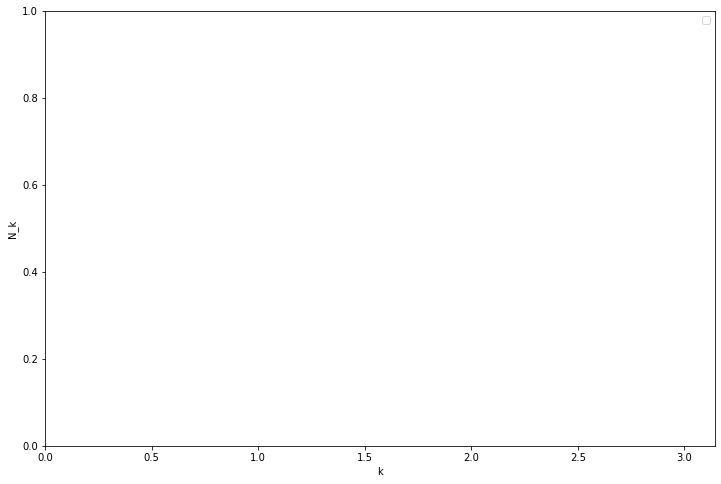

In [11]:
N_inds = ['N_{}'.format(i) for i in range(L)]

plt.figure(figsize=(12, 8))

for i, G in enumerate(Gs):
    if 0.95 < G*L/g_c < 1.05: # Only selecting within 2% of G_c
        plt.plot(k, output_df[N_inds].iloc[i], 
                label='g = {}'.format(np.round(G*L, 3)), # rounding the label to 3 decimal places
                 marker='o') # Putting a dot at each data point
        print(np.sum(output_df[N_inds].iloc[i]))
plt.xlabel('k')
plt.ylabel('N_k')
plt.legend()
plt.xlim(0, np.pi)
plt.show()

At precisely the critical coupling, it seems like Jorge's prediction of perfectly flat distribution is true, just not at the coupling he predicted.

To get a better sense of overall behavior, we can plot at a wider range of coupling. To make sure we don't end up with too many lines, I'll only plot once every 5 datapoints.

sum_k n_k
7.99999999999999
G/Gc
0.26978052970887856
g
0.07840000000000001
sum_k n_k
7.999999999999993
G/Gc
0.43192007716848013
g
0.16134399999999988
sum_k n_k
7.999999999512583
G/Gc
0.5351388711477864
g
0.24428799999999956
sum_k n_k
7.999999999712307
G/Gc
0.5999999999999999
g
0.31830988618379064
sum_k n_k
8.00000000101158
G/Gc
0.704675793412166
g
0.5063480893063582
sum_k n_k
7.999999999191065
G/Gc
0.8714840930989602
g
1.4390021654358067
sum_k n_k
7.999999995725018
G/Gc
1.1417565700004
g
-1.7091854665379158
sum_k n_k
7.99999999662465
G/Gc
1.2499999999999998
g
-1.0610329539459689


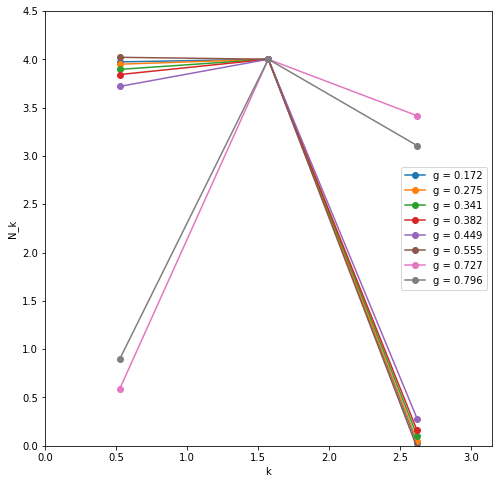

In [12]:
plt.figure(figsize=(8,8))        
Gc = 1/np.sum(k)
for i, G in enumerate(Gs):
    n = np.sum(np.sum(output_df[N_inds].iloc[i]))
    if np.abs(n-N) > 10**-5:
        print('sum_k n_k')
        print(np.sum(output_df[N_inds].iloc[i]))
        print('G/Gc')
        print(G/Gc)
        print('g')
        print(output_df['g'].iloc[i])
    plt.plot(k, output_df[N_inds].iloc[i], 
             label='g = {}'.format(np.round(G*L, 3)), # rounding the label to 3 decimal places
             marker='o') # Putting a dot at each data point

plt.xlabel('k')
plt.ylabel('N_k')
plt.legend()
plt.xlim(0, np.pi)
plt.ylim(0, 4.5) # Limits on values of N_k = n_{k up} + n_{k down} + n_{-k up} + n_{-k down}
plt.show()

Now, we create a Hamiltonian (as Quspin ``quantum_operator`` object) corresponding to our final coupling.
Note that if the number of states in the basis is too big, this operator will eat up a lot of memory. I would recommend not running any of this for L > 5.

Now let's plot the energies at various couplings.

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


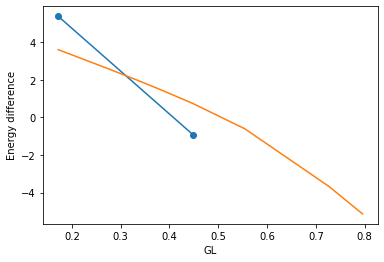

In [20]:
e_es = []
divisible_Gs = []
for i, G in enumerate(Gs):
    if i%4 == 0: # Only using indices that are multiples of 4
        h = ham_op_2(L, G, k, basis=basis)
        e, v = h.eigsh(k=1, which = 'SA') # we only need the 0th energy
        e_es += [e[0]]
    
        divisible_Gs += [G]

plt.plot(np.array(divisible_Gs)*L, e_es, marker='o')
plt.plot(output_df['G']*L, output_df['energy'])
plt.xlabel('GL')
plt.ylabel('Energy difference')
# plt.ylim(-10**-12, 10**-12)
plt.show()

## Charge gap/chemical potential
Let's define some more quantities: First, chemical potential is (more or less) the energy
required to add a fermion to the system. We can estimate it as
\begin{equation}
\mu = \frac{E(N+1)- E(N) + E(N) - E(N-1)}{2}
= \frac{E(N+1) -E(N-1)}{2}
\end{equation}
where $E(M)$ is the ground state energy with $M$ fermions.

We can define a similar quantity, the charge gap (which I will call $\Delta$):
\begin{equation}
\Delta  = \frac{E(N+1) + E(N-1) - 2 E(N)}{2}.
\end{equation}

Let's see how these behave around our critical point:

In [21]:
Gss = np.linspace(0, G_final, 20)

b_plus = form_basis(2*L, Nup + 1, Ndown)
b_minus = form_basis(2*L, Nup - 1, Ndown)
e_plus = np.zeros(len(Gss))
energies = np.zeros(len(Gss))
e_minus = np.zeros(len(Gss))
for i, G in enumerate(Gss):
    h_plus = ham_op_2(L, G, k, basis=b_plus)
    h = ham_op_2(L, G, k, basis=basis)
    h_minus = ham_op_2(L, G, k, basis=b_minus)
    ep, vp = h_plus.eigsh(k=1, which='SA')
    e, v = h.eigsh(k=1, which='SA')
    em, vm = h_minus.eigsh(k=1, which='SA')
    e_plus[i] = ep[0]
    energies[i] = e[0]
    e_minus[i] = em[0]

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Part

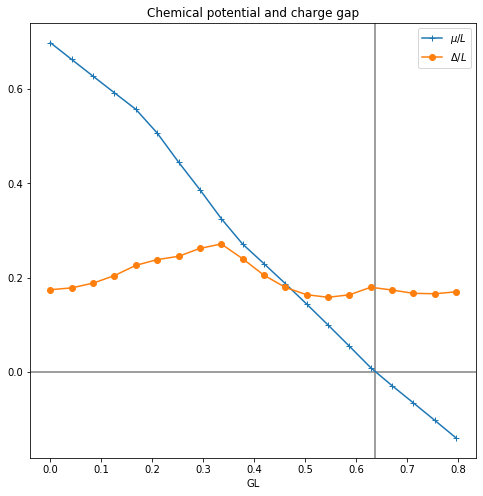

In [22]:
mu = (e_plus - e_minus)/2
cg = (e_plus + e_minus - 2*energies)/2
plt.figure(figsize=(8,8))
plt.axhline(0, color='gray')
plt.axvline(g_c, color='gray')
plt.plot(Gss*L, mu/L, label = '$\mu/L$', marker = '+')
plt.plot(Gss*L, cg/L, label = '$\Delta/L$', marker = 'o')
plt.xlabel('GL')
plt.title('Chemical potential and charge gap')
plt.legend()
plt.show()